62

In [14]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np 

def make_scaler2(x_tmp ):
    #this will get a min and max for each channel
    
    linx= []
    
    x_tmp=x_tmp.reshape(x_tmp.shape[0],x_tmp.shape[1],x_tmp.shape[3]**2)#color in 2nd channel

    for color in range(x_tmp.shape[1]):
        linx.append(np.zeros(x_tmp.shape[0]*x_tmp.shape[2]) ) #x.shape[2] =101*101
        for image in range(x_tmp.shape[0]):
            linx[color][image*x_tmp.shape[2] : (image+1)*x_tmp.shape[2]] = x_tmp[image][color]

    
    minmax_dict = {"max": [],"min": [] } 
    for color in range(x_tmp.shape[1]):
        minmax_dict['max'].append(linx[color].reshape(-1).max())
        minmax_dict['min'].append(linx[color].reshape(-1).min())
        

            
    #print(linx[0]==linx[1])#linx[1].reshape(-1, 1).shape)
    return minmax_dict

def scale_data2(x_tmp, minmax_dict):
    linx= []
    
    #reshape
    x_tmp=x_tmp.reshape(x_tmp.shape[0],x_tmp.shape[1],x_tmp.shape[3]**2)
    
    #get it in a line
    for color in range(x_tmp.shape[1]):
        linx.append(np.zeros(x_tmp.shape[0]*x_tmp.shape[2]) ) #x.shape[2] =101*101
        for image in range(x_tmp.shape[0]):
            linx[color][image*x_tmp.shape[2] : (image+1)*x_tmp.shape[2]] = x_tmp[image][color]
        print(linx[color].max())
    #transform/scale
    transx = []
    for color in range(x_tmp.shape[1]): 
        X_std = (linx[color] - minmax_dict["min"][color]) / (minmax_dict["max"][color] - minmax_dict["min"][color])
        #X_scaled = X_std * (minmax_dict["max"][color] - minmax_dict["min"][color]) + minmax_dict["min"][color]
        transx.append(X_std)
 
    #store in original 4d array
    for image in range(x_tmp.shape[0]):
        for color in range(x_tmp.shape[1]):
            x_tmp[image][color] = transx[color][image*x_tmp.shape[2] : (image+1)*x_tmp.shape[2]].reshape(1,-1) 
    #reshape back to original dimensions
    x_tmp = x_tmp.reshape(x_tmp.shape[0],1,100,100)
    return x_tmp

In [3]:
from astropy.nddata.utils import Cutout2D
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale

OUT_PATH = "/run/media/toyonagar/Lexar/out/out"
MERGED_PATH = "/run/media/toyonagar/Lexar/merged/merged_"
hm_lenses = int(input("How many lenses do you want to merge with associated cutouts? "))

def normalize( all_cutouts, all_lenses, hm_lenses): #only for 1 color channel
    bad_images = []
    for lens_number in range(hm_lenses):
        try:
            tmp_lens = all_lenses[lens_number][0].reshape(-1,)
            tmp_lens = minmax_scale(tmp_lens, feature_range = (all_cutouts[lens_number][0].min(), all_cutouts[lens_number][0].max()*0.75))
            all_lenses[lens_number][0] = tmp_lens.reshape(all_lenses.shape[2],all_lenses.shape[2])
    
        except:
            bad_images.append(lens_number)
            print ("image contains NaN")
    
    hm_lenses -=len(bad_images)        
    all_lenses = np.delete(all_lenses,bad_images, axis=0)
    all_cutouts = np.delete(all_cutouts,bad_images, axis=0)

    
 
    return all_cutouts, all_lenses
    

def load_images(sample_num):
    
    try:
        lens = fits.open("lens_image_"+str(sample_num)+".fits")[0].data #PATH will  run dir
    except:
        print "lens messed up"
    try:
        cutout = fits.open(OUT_PATH+str(sample_num)+".fits")[0].data 
    except:
        print "out messed up"
    try:
        cutout = cutout.reshape(1,cutout.shape[0],cutout.shape[1])
        lens = lens.reshape(1,lens.shape[0],lens.shape[1])
    except: 
        print "reshape" 
    return cutout, lens
    

def save_images(hm_lenses, merged):
    
    for image in range(len(merged)):
        fits.writeto(MERGED_PATH + str(image)+'.fits', merged[image], overwrite =True) #PATH
    

def sum_images(all_cutouts, all_lenses): #only sums in 2D, no color channel
    summed = []
    for image_number in range(hm_lenses):    
        summed.append(np.add(all_cutouts[image_number][0], all_lenses[image_number][0])) 
    return summed


all_cutouts = np.zeros((hm_lenses,1,100,100))
all_lenses = np.zeros((hm_lenses,1,100,100))

bad_images = [] #keep track of and remove bad images later

for i in range(hm_lenses):
    try:
        all_cutouts[i], all_lenses[i] = load_images(i)
    except:
        bad_images.append(i)
        print("couldnt find image: " +str(i))
        
hm_lenses -=len(bad_images)        
all_cutouts = np.delete(all_cutouts,bad_images, axis=0)
all_lenses = np.delete(all_lenses,bad_images, axis=0)
    
print("images loaded") 

all_cutouts, all_lenses = normalize(all_cutouts, all_lenses, hm_lenses)
print("images normalized")   
    
merged = sum_images(all_cutouts, all_lenses)  

print("images merged") 

bad_images = []
for image in range(len(merged)):
    try:
        tmp_image = merged[image].reshape(-1,)
        tmp_image = minmax_scale(tmp_image, feature_range = (0,1))
        merged[image] = tmp_image.reshape(merged[image].shape[0],merged[image].shape[1])
        
        tmp_out = all_cutouts[image][0].reshape(-1,)
        tmp_out = minmax_scale(tmp_out, feature_range = (0,1))
        all_cutouts[image][0] = tmp_out.reshape(all_cutouts[image][0].shape[0],all_cutouts[image][0].shape[1])
    except:
        bad_images.append(image)
        print ("image contains NaN")


        
hm_lenses -=len(bad_images)        
merged = np.delete(merged,bad_images, axis=0)



    
print ("images re-normalized")

save_images(hm_lenses, merged)

print(" merged images saved ")

How many lenses do you want to merge with associated cutouts? 5000
out messed up
reshape
couldnt find image: 2
out messed up
reshape
couldnt find image: 14
out messed up
reshape
couldnt find image: 15
out messed up
reshape
couldnt find image: 18
out messed up
reshape
couldnt find image: 19
out messed up
reshape
couldnt find image: 20
out messed up
reshape
couldnt find image: 22
out messed up
reshape
couldnt find image: 23
out messed up
reshape
couldnt find image: 25
out messed up
reshape
couldnt find image: 29
out messed up
reshape
couldnt find image: 30
out messed up
reshape
couldnt find image: 31
out messed up
reshape
couldnt find image: 35
out messed up
reshape
couldnt find image: 37
out messed up
reshape
couldnt find image: 38
out messed up
reshape
couldnt find image: 39
out messed up
reshape
couldnt find image: 42
out messed up
reshape
couldnt find image: 46
out messed up
reshape
couldnt find image: 49
out messed up
reshape
couldnt find image: 51
out messed up
reshape
couldnt find

out messed up
reshape
couldnt find image: 840
out messed up
reshape
couldnt find image: 848
out messed up
reshape
couldnt find image: 850
out messed up
reshape
couldnt find image: 858
out messed up
reshape
couldnt find image: 876
out messed up
reshape
couldnt find image: 888
out messed up
reshape
couldnt find image: 891
out messed up
reshape
couldnt find image: 895
out messed up
reshape
couldnt find image: 900
out messed up
reshape
couldnt find image: 916
out messed up
reshape
couldnt find image: 927
out messed up
reshape
couldnt find image: 935
out messed up
reshape
couldnt find image: 949
out messed up
reshape
couldnt find image: 993
out messed up
reshape
couldnt find image: 1033
out messed up
reshape
couldnt find image: 1040
out messed up
reshape
couldnt find image: 1045
out messed up
reshape
couldnt find image: 1076
out messed up
reshape
couldnt find image: 1092
out messed up
reshape
couldnt find image: 1144
out messed up
reshape
couldnt find image: 1173
out messed up
reshape
could

out messed up
reshape
couldnt find image: 2417
out messed up
reshape
couldnt find image: 2419
out messed up
reshape
couldnt find image: 2420
out messed up
reshape
couldnt find image: 2421
out messed up
reshape
couldnt find image: 2424
out messed up
reshape
couldnt find image: 2425
out messed up
reshape
couldnt find image: 2427
out messed up
reshape
couldnt find image: 2432
out messed up
reshape
couldnt find image: 2436
out messed up
reshape
couldnt find image: 2443
out messed up
reshape
couldnt find image: 2446
out messed up
reshape
couldnt find image: 2463
out messed up
reshape
couldnt find image: 2479
out messed up
reshape
couldnt find image: 2519
out messed up
reshape
couldnt find image: 2523
out messed up
reshape
couldnt find image: 2530
out messed up
reshape
couldnt find image: 2533
out messed up
reshape
couldnt find image: 2534
out messed up
reshape
couldnt find image: 2546
out messed up
reshape
couldnt find image: 2547
out messed up
reshape
couldnt find image: 2551
out messed up

image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contains NaN
image contai

In [573]:
import pandas as pd
dataframe = pd.read_csv("with_zphot.tsv",delimiter=";")

In [52]:

import numpy as np


np.save("real_cutouts.npy(20,1,100,100)",all_cutouts)
np.save("sim_lenses.npy(20,1,100,100)",all_lenses)

In [60]:
tmp = np.load("sim_lenses.npy(20,1,100,100).npy")

('no-neg mean: 0.28821090257', 'negative samples mean: 0.172155434138', 0.0094558316953108606)


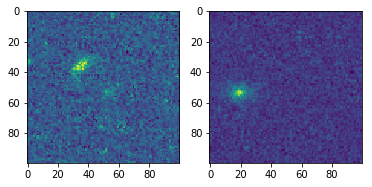

In [72]:
#For testing diff between negatives and merged images
from astropy.nddata.utils import Cutout2D
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale

im=295
m = fits.open("/run/media/toyonagar/Lexar/merged/merged_"+str(im)+".fits")[0].data
m1 = fits.open("/run/media/toyonagar/Lexar/merged1/merged_"+str(im)+".fits")[0].data
o = fits.open("/run/media/toyonagar/Lexar/negatives/out"+str(im)+".fits")[0].data
print ("no-neg mean: "+str(m.mean()), "negative samples mean: "+str(o.mean()), m1.mean()) 
plt.subplot(121)
plt.imshow(m) 
plt.subplot(122)
plt.imshow(o)


(array([  9.98000000e+03,   1.00000000e+01,   3.00000000e+00,
          2.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

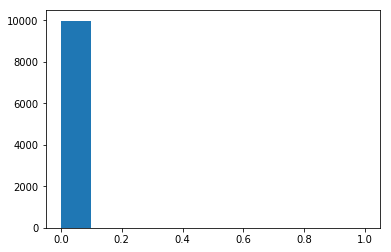

In [196]:
plt.hist(o.reshape(-1))

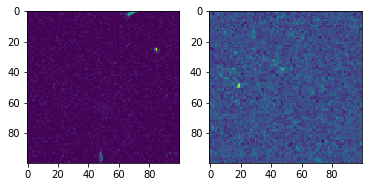

In [13]:
#import all the data. This will load the data into "ims" (set_size, color, 100,100) and "y" (set_size , 1) 
import numpy as np
import os 
from astropy.io import fits

NEG_PATH = "/run/media/toyonagar/Lexar/negatives/"
POS_PATH = "/run/media/toyonagar/Lexar/merged/"
OLD_POS_PATH = "/run/media/toyonagar/Lexar/merged1/"

set_size=500
pos = np.ones((set_size, 1, 100, 100))
oldpos = np.ones((set_size, 1, 100, 100))
neg = np.ones((set_size, 1, 100, 100))
#load the negatives into even numbered indices (including 0)
count =0
for filename in os.listdir(POS_PATH):
    if filename.endswith(".fits") and count<set_size: 
        pos[count] = fits.open(POS_PATH+filename)[0].data
        
        
        count+=1
count =0
for filename in os.listdir(OLD_POS_PATH):
    if filename.endswith(".fits") and count<set_size: 
      
        oldpos[count] = fits.open(OLD_POS_PATH+filename)[0].data

        count+=1    
    
count =0
for filename in os.listdir(NEG_PATH):
    if filename.endswith(".fits") and count<set_size: 
     
        neg[count] = fits.open(NEG_PATH+filename)[0].data
        
        count+=1
print("the averages of 500 samples from each respective group: ")
print ("positive samples without neg pixels: "+str(pos.mean()))
print( "negative samples: "+ str(neg.mean()))
print( " positive samples with neg pix: "+str(oldpos.mean()))         


the averages of 500 samples from each respective group: 
positive samples without neg pixels: 0.185752629454
negative samples: 0.233798937586
 positive samples with neg pix: 0.347581070713


In [227]:
combined = np.concatenate((neg, pos))

In [228]:
combined.mean()

0.20977578351989137

In [10]:
s= "\t" +"pixel     1 100 lenses/lens_image_"+str(1000)+".fits" +"\n" 

In [11]:
len(s)

45